In [1]:
import sys
sys.path.insert(0, '../..')

# general
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sns.set()
warnings.filterwarnings("ignore")

# local
from sklearn_crfsuite import metrics
from core.stats import Statistics
from core.utils import load_dataset, format_number
from core.plots import plot_histogram, plot_learning_curve
from core.learning import LearningAnalyser
from core.reports import (
    compute_user_error,
    generate_comparison_report,
    generate_test_groups_comparison_report,
    generate_learning_report
)
from core.dataset import DatasetAnalyser, DatasetGroup

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

from core.latex import create_latex_tables_generator

import numpy as np
np.random.seed(3453562)

# 1. General statistics
## 1.1. Read data

In [2]:
df = load_dataset('../../data/bank_complaints/bank_complaints-dataset.csv')

## 1.2. Statistics

In [3]:
stats = Statistics(df)

### 1.2.1. General

In [4]:
stats.general

,value
metric,
total_annotations,9415
unique_items,1986
unique_users,145
total_annotation_time,02h 36m 19s


### 1.2.2. Annotations per item

In [5]:
stats.annotations_per_item

,data__item_id
count,1986.000000
mean,4.740685
std,1.825850
min,1.000000
25%,3.000000
50%,5.000000
75%,6.000000
max,11.000000


### 1.2.3. Annotations per user

In [6]:
stats.annotations_per_user

,user__id
count,145.000000
mean,64.931034
std,55.546609
min,11.000000
25%,50.000000
50%,50.000000
75%,50.000000
max,450.000000


### 1.2.4. Average annotation time over time

,value
index,
10,13.248470
20,11.315549
30,10.765567
40,10.070734
60,12.055744
70,8.783930
80,9.137001
90,8.394636


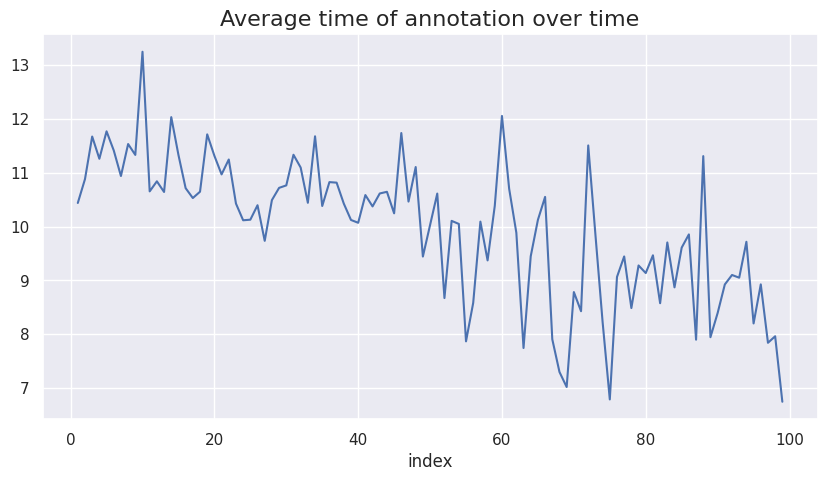

In [7]:
plt.figure(figsize=(10, 5))
plt.title("Average time of annotation over time", fontsize=16)
df_times = stats.average_time_per_annotation
df_times['value'].plot()
df_times[df_times.index % 10 == 0]

# 2. Confidence intervals
## 2.1. Compute user's annotation quality metrics
- In this section we aggregate the raw result to compute the quality metrics value per user
- To measure the quality of user's annotation we use: accuracy, recall, f1 and precision metrics
- Mean error is computed for each user in each test_group separately.<br/>
This way we can check how each user did in each test conditions

In [8]:
METRICS_COLUMNS = ["f1", "precision", "recall", "annotation_time", "count"]
LABELS = ["Geopolitical", "Geographical", "Organization", "Time", "Person"]

In [9]:
def metrics_function(y_true: pd.Series, y_pred: pd.Series):
    return {
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'f1': f1_score(y_true, y_pred, average='macro'),
        'accuracy': accuracy_score(y_true, y_pred),
    }
  
    
df_user_error = compute_user_error(df, metrics_function)

## 2.2. Compute confidence intervals for test groups
In this section we compute the confidence intervals for the percentage quality change between the control group and each of the test groups.

In [10]:
dataset = DatasetAnalyser(df_user_error, METRICS_COLUMNS)

### 2.2.1. Compering: test groups vs control group

In [11]:
df_ci_h1, df_percentage_ci_h1, df_p_value_h1, df_cohen_d_h1 = generate_comparison_report(dataset)

#### Confidence intervals

In [12]:
df_ci_h1

f1  precision    recall  \
group_name              quantile                                  
high quality feedback   0.05      0.007135  -0.024183 -0.005597   
                        0.5       0.043133   0.018938  0.029021   
                        0.95      0.081295   0.063468  0.066988   
low quality feedback    0.05     -0.125873  -0.138757 -0.117883   
                        0.5      -0.010265  -0.023811  0.000734   
                        0.95      0.101920   0.083177  0.117430   
medium quality feedback 0.05     -0.041986  -0.059485 -0.051199   
                        0.5       0.022868   0.011128  0.018099   
                        0.95      0.091904   0.084636  0.092905   

                                  annotation_time      count  
group_name              quantile                              
high quality feedback   0.05            -1.439203  -6.142039  
                        0.5              0.454726   5.955690  
                        0.95             2.467519  19.275913  
low quality feedback    0.05            -8.557450  -4.666667  
                        0.5             -5.713233  11.532444  
                        0.95            -2.889403  28.011667  
medium quality feedback 0.05            -4.515635 -26.400000  
                        0.5             -0.713144  17.714667  
                        0.95             2.791375  58.470000

#### Percentage confidence intervals

In [13]:
df_percentage_ci_h1

f1  precision    recall  \
group_name              quantile                                  
high quality feedback   0.05      0.036093  -0.101409 -0.025440   
                        0.5       0.218179   0.079413  0.131908   
                        0.95      0.411216   0.266144  0.304478   
low quality feedback    0.05     -0.292453  -0.294584 -0.271065   
                        0.5      -0.023849  -0.050551  0.001687   
                        0.95      0.236802   0.176587  0.270022   
medium quality feedback 0.05     -0.149891  -0.196284 -0.171873   
                        0.5       0.081639   0.036718  0.060759   
                        0.95      0.328096   0.279275  0.311881   

                                  annotation_time     count  
group_name              quantile                             
high quality feedback   0.05            -0.127661 -0.105583  
                        0.5              0.040335  0.102380  
                        0.95             0.218874  0.331358  
low quality feedback    0.05            -0.571705 -0.092105  
                        0.5             -0.381689  0.227614  
                        0.95            -0.193035  0.552862  
medium quality feedback 0.05            -0.407528 -0.451539  
                        0.5             -0.064360  0.302987  
                        0.95             0.251916  1.000057

#### p-value

In [14]:
df_p_value_h1

,f1,precision,recall,annotation_time,count,group_name
0,0.9831,0.7524,0.9053,0.6476,0.7527,high quality feedback
0,0.4453,0.3684,0.5088,0.0000,0.8749,low quality feedback
0,0.7048,0.5935,0.6450,0.3930,0.7842,medium quality feedback


#### Cohen's D

In [15]:
df_cohen_d_h1

,f1,precision,recall,annotation_time,count,group_name
0,0.454470,0.156603,0.313015,0.076561,0.168944,high quality feedback
0,-0.051811,-0.125377,0.003584,-1.126966,0.375526,low quality feedback
0,0.194997,0.088147,0.145261,-0.117023,0.262185,medium quality feedback


#### Ploting histograms for the difference: test groups vs control group

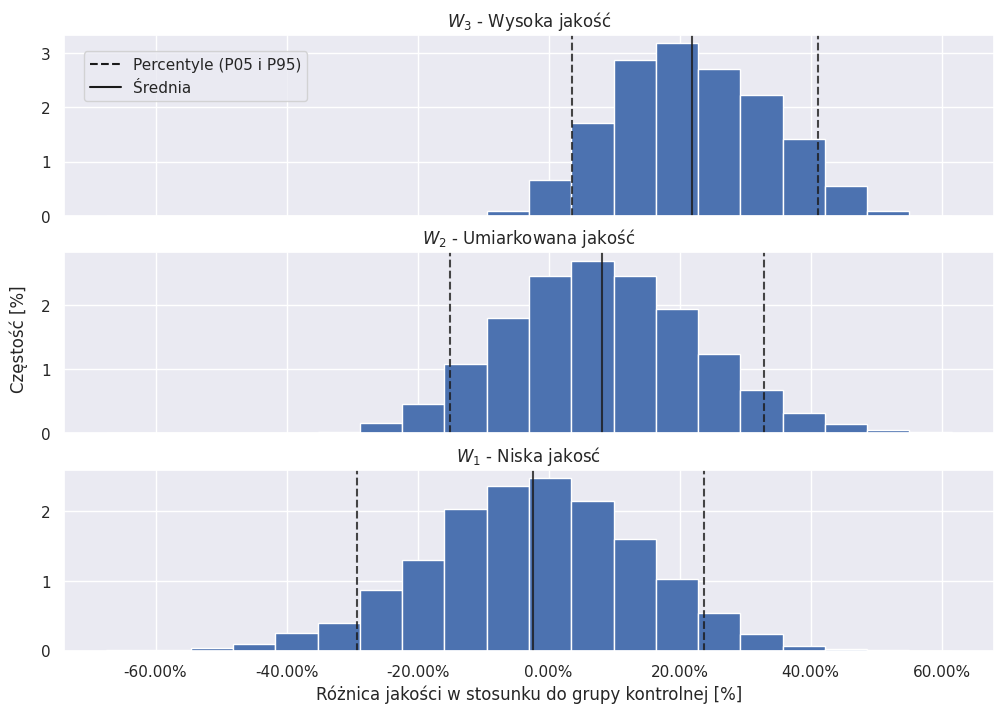

In [16]:
metric_index = 0
plot_histogram(dataset, metric_index)

### 2.2.2. Comparing: test groups with each other

In [17]:
df_ci_h2, df_p_value_h2, df_cohen_d_h2 = generate_test_groups_comparison_report(dataset)

#### Confidence interval

In [18]:
df_ci_h2

f1  precision    recall  annotation_time     count
group_name  quantile                                                          
high_low    0.05     -0.050778  -0.128129 -0.157619         0.179415 -0.487316
            0.5       0.242028   0.129963  0.130221         0.422024 -0.125234
            0.95      0.562168   0.424410  0.443987         0.674782  0.264265
high_medium 0.05     -0.179449  -0.266568 -0.233207        -0.245247 -0.951492
            0.5       0.136540   0.042695  0.071150         0.104695 -0.200607
            0.95      0.447770   0.363390  0.367281         0.503196  0.564651
medium_low  0.05     -0.223190  -0.215223 -0.276588        -0.066861 -0.719143
            0.5       0.105487   0.087269  0.059072         0.317329  0.075373
            0.95      0.458473   0.417689  0.419377         0.689025  0.841643

#### p-value

In [19]:
df_p_value_h2

,f1,precision,recall,annotation_time,count,group_name
0,0.9126,0.7817,0.7562,0.9991,0.2866,high_low
0,0.7609,0.5834,0.6593,0.6571,0.3075,high_medium
0,0.6990,0.6739,0.6044,0.9162,0.5729,medium_low


#### Cohen's D

In [20]:
df_cohen_d_h2

,f1,precision,recall,annotation_time,count,group_name
0,1.723162,1.016452,0.951169,3.871704,-0.743473,high_low
0,1.043064,0.331404,0.565525,0.655281,-0.627671,high_medium
0,0.685506,0.608322,0.377857,1.944363,0.225508,medium_low


# 3. Analyse learning curve

In [21]:
df['annotation_eval'] = (df['reference__output'] == df['annotation__output']).astype(int)
df_high = df.query("test_group == 'high quality feedback'")

In [22]:
learning = LearningAnalyser(df_high)

#### Learning curve stats

In [23]:
learning_report = generate_learning_report(learning)
learning_report

,Metryka,Wartość
0,$\alpha$,0.0
1,$\beta$,0.049
2,$\alpha_r$,+4.55%
3,$\beta_r$,+21.15%


#### Learning curve plot

In [24]:
# styling fix
learning_report['Wartość'] = learning_report['Wartość'].astype(str).str.replace(".", ",")

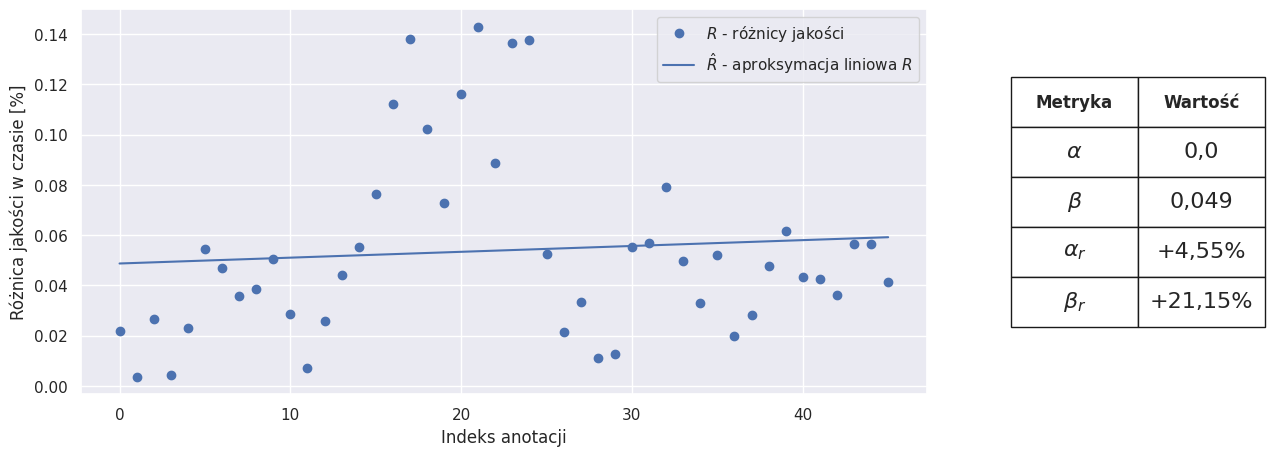

In [25]:
plot_learning_curve(learning, learning_report)

## Generate latex tables

In [27]:
latex_generator = create_latex_tables_generator(
    df_percentage_ci_h1=df_percentage_ci_h1,
    df_p_value_h1=df_p_value_h1,
    df_cohen_d_h1=df_cohen_d_h1,
    df_ci_h2=df_ci_h2,
    df_p_value_h2=df_p_value_h2,
    df_cohen_d_h2=df_cohen_d_h2
)

In [28]:
print(latex_generator.get_results_table("f1"))


\begin{table}[H]
\centering
\caption{}
\label{tab:my-table}
\begin{tabular}{cccccc}
\rowcolor[HTML]{EFEFEF} 
\multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\textbf{Warunek}} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{05}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$\mu$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{95}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$p$} &
  \boldmath$d$ \\ \hline
\rowcolor[HTML]{EFEFEF} 
\multicolumn{6}{c}{\cellcolor[HTML]{EFEFEF}Hipoteza $H_1$ -- zmiana w metryce XXXX}                                                                                                        \\ \hline
        \multicolumn{1}{c|}{$W_1$} & \multicolumn{1}{c|}{+3.61\%} & \multicolumn{1}{c|}{+21.82\%} & \multicolumn{1}{c|}{+41.12\%} & \multicolumn{1}{c|}{0.9831} & 0.45 \\ \hline\multicolumn{1}{c|}{$W_2$} & \multicolumn{1}{c|}{-14.99\%} & \multicolumn{1}{c|}{+8.16\%} & \multicolumn{1}{c|}{+32.81\%} & \multicolumn{1}{c|}